In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mosfit
import time
import sys

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
#import sqlalchemy 
import random
import json
from collections import OrderedDict
from scipy import interpolate
# from dust_extinction.averages import GCC09_MWAvg
# from dustmaps.sfd import SFDQuery
from astropy.coordinates import SkyCoord
from astropy import units as u
import os

In [4]:
# !mosfit -m tde -e ./astrocatalogs/tde-1980-2025/J030257.json --extra-bands u g r i z y
directory = '/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13'
meta_data = pd.read_csv(directory+"/meta_data_panda.csv")
meta_data

,Unnamed: 0,bhmass,stellar_mass,scaled_b,redshift,label
0,0,100000.0,0.3,0.0,0.01,0.0
1,1,100000.0,0.3,0.0,0.12,1.0
2,2,100000.0,0.3,0.0,0.23,2.0
3,3,100000.0,0.3,0.0,0.34,3.0
4,4,100000.0,0.3,0.0,0.45,4.0
...,...,...,...,...,...,...
23995,23995,100000000.0,1.0,2.0,0.56,23995.0
23996,23996,100000000.0,1.0,2.0,0.67,23996.0
23997,23997,100000000.0,1.0,2.0,0.78,23997.0
23998,23998,100000000.0,1.0,2.0,0.89,23998.0


In [5]:

#Define the light curve class
class LightCurve():
    """
    A basic transient model
    """

    def __init__(self, times, mags, true_mags, filters, snrs, err, mwebv = 0, mosfitphase=None): #theta?
        """
        Parameters:
        ----------
        ...

        """
        self.times = times
        self.mags = mags
        self.true_mags = true_mags
        self.filters = filters
        self.snrs = snrs
        self.errs = err
        #self.theta = theta
        self.mwebv = mwebv
        self.mosfitphase=mosfitphase

    def get_df(self):
        ## Return a DataFrame withe time,mag,filter,snr,err
        #print(self.mags)
        #print(self.true_mags)
        df_lc = pd.DataFrame({"timeMJD":self.times, "mags":self.mags, "truemags":self.true_mags,
                              "errors":self.errs, "SNRs":self.snrs,
                              "filter":self.filters})
        if self.mosfitphase is not None:
            df_lc['MOSFITday'] = self.mosfitphase
            
        return df_lc
        



opsim_file = '/d6/CAC/gcontardo/Data/baseline_v4.0_10yrs.db'

opsim = os.path.basename(opsim_file).replace('.db','')
print(opsim)

# This reads in the OpSim File
# This file is a database containing many,many pointings of LSST
conn = sqlite3.connect(opsim_file)    

#Now in order to read in pandas dataframe we need to know table name
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';") 
#proposalId
df_v4 = pd.read_sql_query('SELECT fieldRA, fieldDec, seeingFwhmEff, observationStartMJD, filter, fiveSigmaDepth, skyBrightness  FROM observations', conn)
conn.close()

baseline_v4.0_10yrs


In [6]:
def get_MOSIFT(json_file):
    ## Utility function that return a list of times and a dictionnary of the list of mags (keys are the bands) 
    ## 
    band_list_cln = ['u','g','r','i','z','y']
    
    max_phase=1000
    
    #print(tmin, tmax)
    with open(json_file, 'r', encoding = 'utf-8') as f:
        data = json.loads(f.read())
        if 'name' not in data:
            data = data[list(data.keys())[0]]
    
    photo = data['photometry']
    model = data['models'][0]
    
    band_attr = ['band', 'instrument', 'telescope', 'system', 'bandset']
    band_list2 = list(set([tuple(x.get(y, '')
                                for y in band_attr) for x in photo
                                if 'band' in x and 'magnitude' in x]))
    
    ## Still not too sure why I have two realizations when I run mosfit but?? 
    ## TODO Check how many real we got for all the TDEs generated
    realiza = []
    for x in photo:
        realiza.append(x['realization'])
    realiza = np.unique(realiza)
    
    rea = realiza[0] ## 
    
    times = {b:[] for b in band_list_cln} # 
    magsMOS = {b:[] for b in band_list_cln}
    for x in photo:
        if x['realization']==rea:
            times[x['band']].append(float(x['time']))
            magsMOS[x['band']].append(float(x['magnitude']))
    
    
    # Have to cheat for the times...
    for b in band_list_cln:
        times[b] = np.arange(max_phase)
    return times['u'], magsMOS

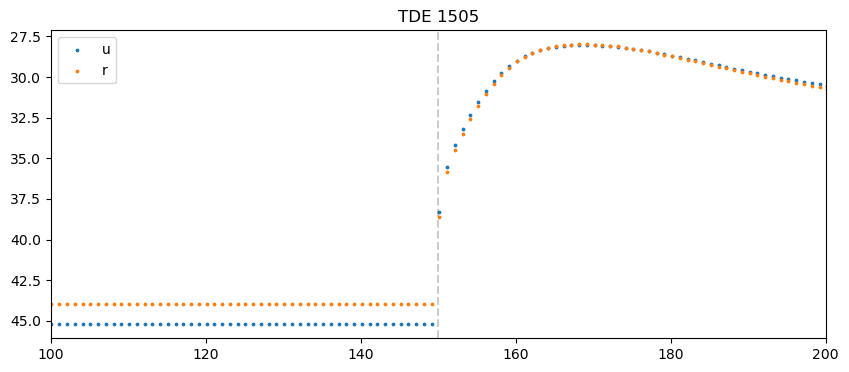

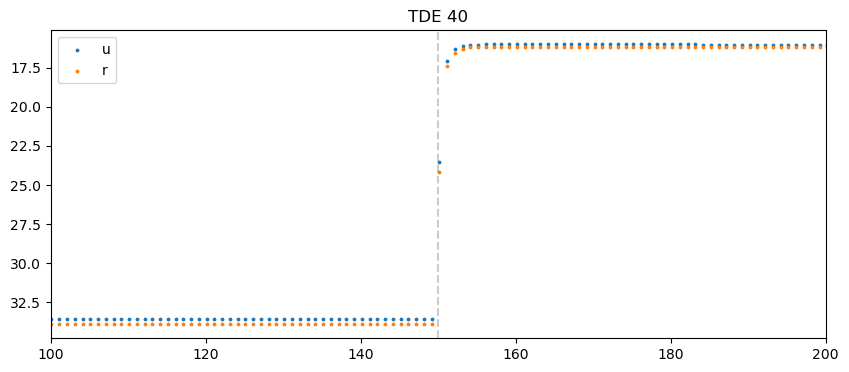

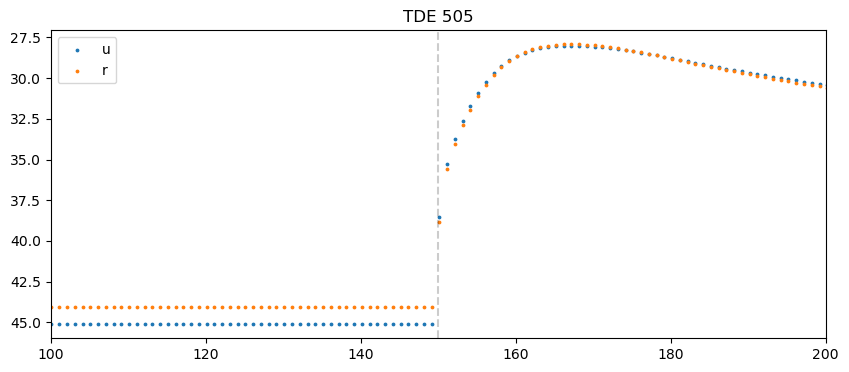

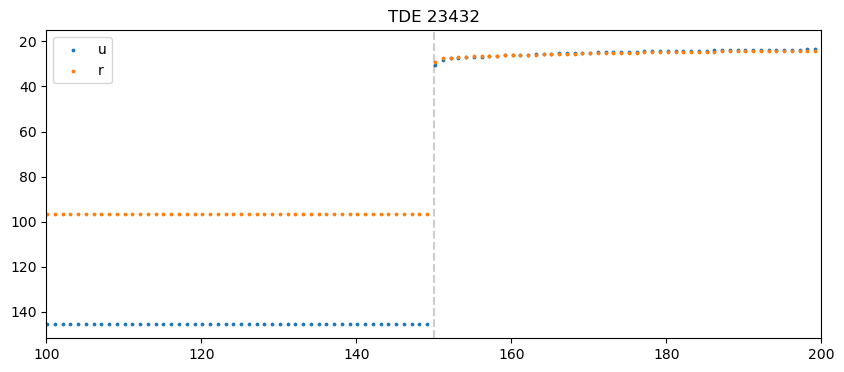

In [32]:

for idx in [1505, 40, 505, 23432]:
    json_Tde = f"/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_{idx}.json"
    times,mags = get_MOSIFT(json_Tde)
    
    plt.figure(figsize=(10,4))
    plt.axvline(150, color='k', ls='--', alpha=.2)
    plt.scatter(times, mags['u'], label='u', s=3)
    plt.scatter(times, mags['r'], label='r', s=3)
    plt.legend()
    plt.gca().invert_yaxis()
    plt.title(f"TDE {idx}")
    plt.xlim(100,200)

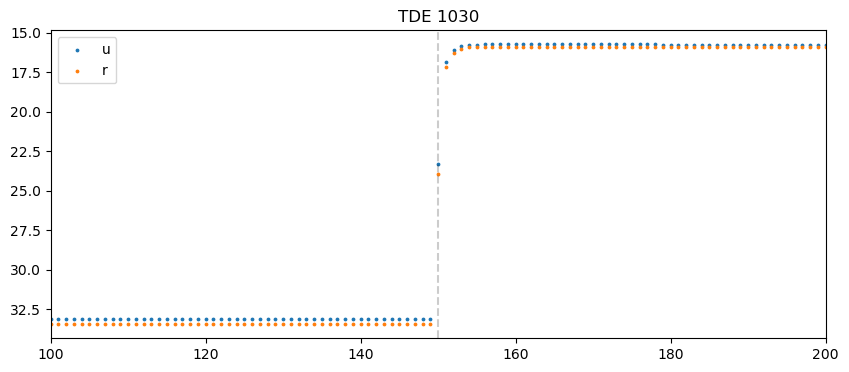

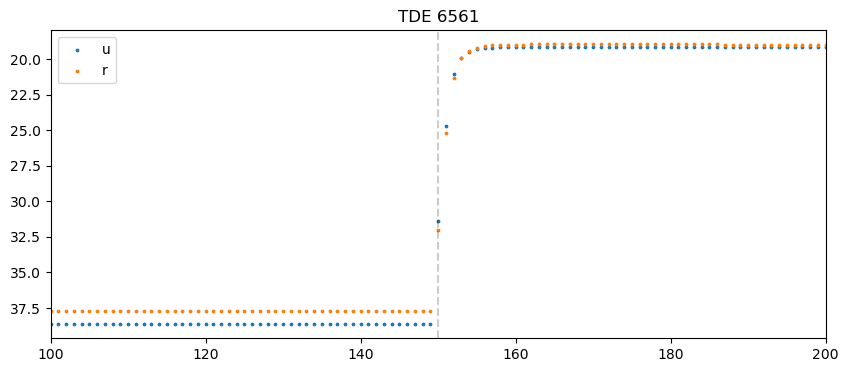

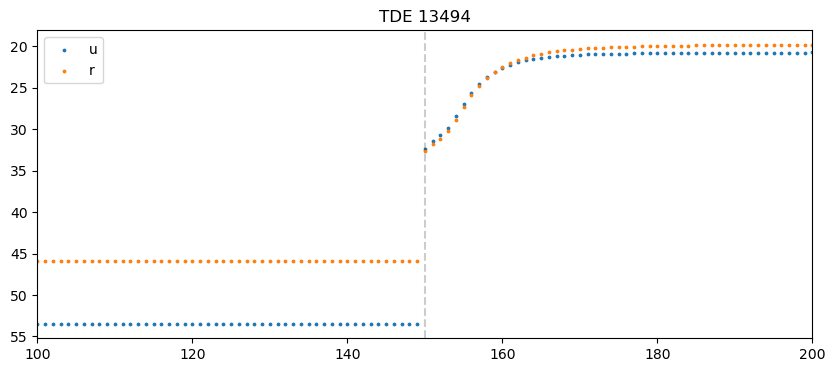

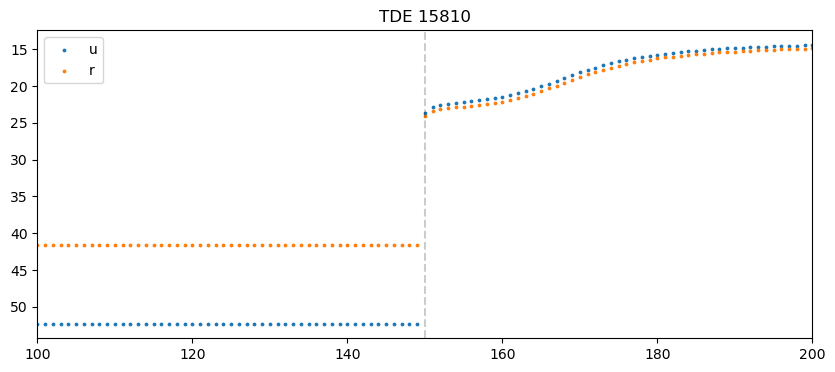

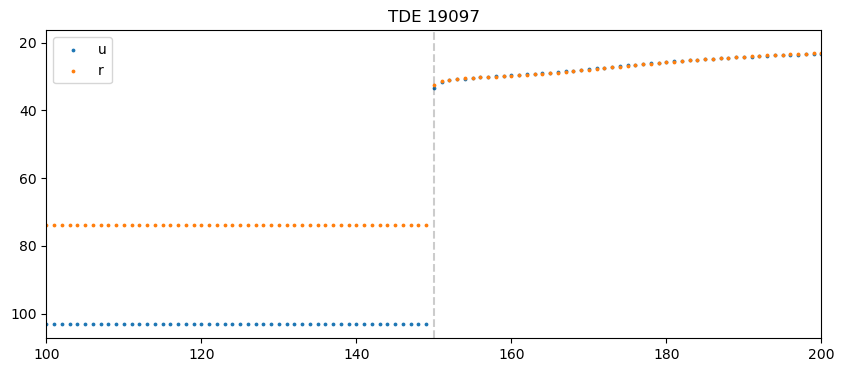

In [28]:

for i in range(5):
    idx = np.random.randint(0,24000)
    json_Tde = f"/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_{idx}.json"
    times,mags = get_MOSIFT(json_Tde)

    while np.min(mags['u'])>24:
        idx = np.random.randint(0,24000)
        json_Tde = f"/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_{idx}.json"
        times,mags = get_MOSIFT(json_Tde)
        
    plt.figure(figsize=(10,4))
    plt.axvline(150, color='k', ls='--', alpha=.2)
    plt.scatter(times, mags['u'], label='u', s=3)
    plt.scatter(times, mags['r'], label='r', s=3)
    plt.legend()
    plt.gca().invert_yaxis()
    plt.title(f"TDE {idx}")
    plt.xlim(100,200)

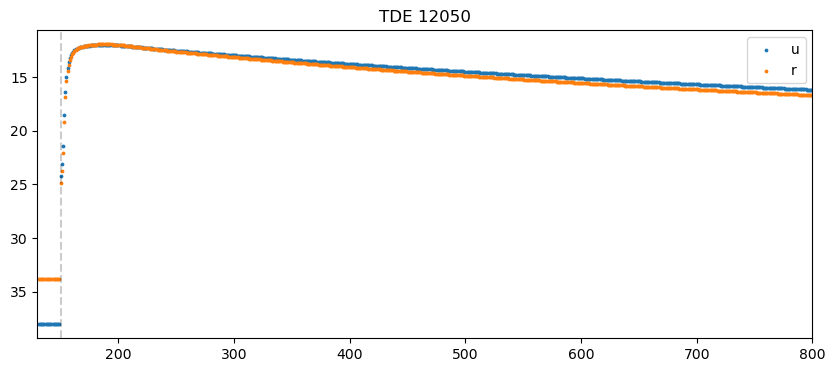

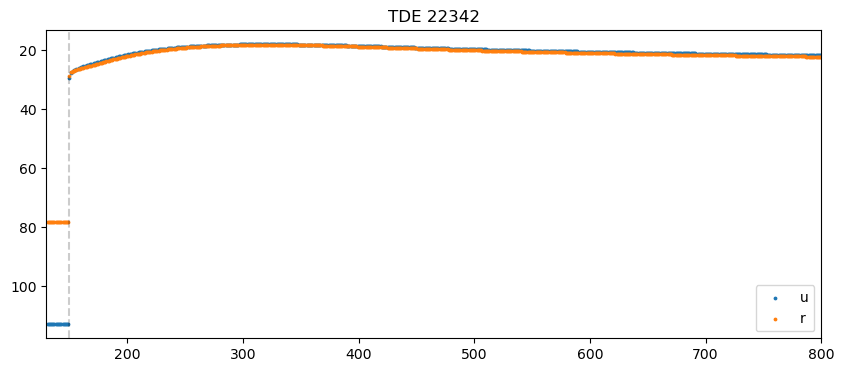

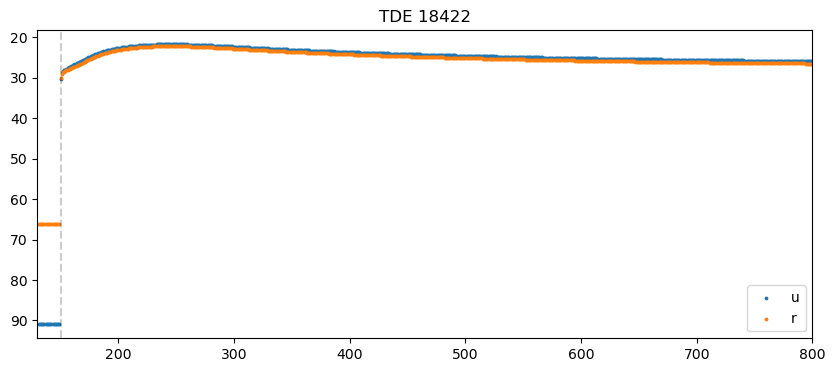

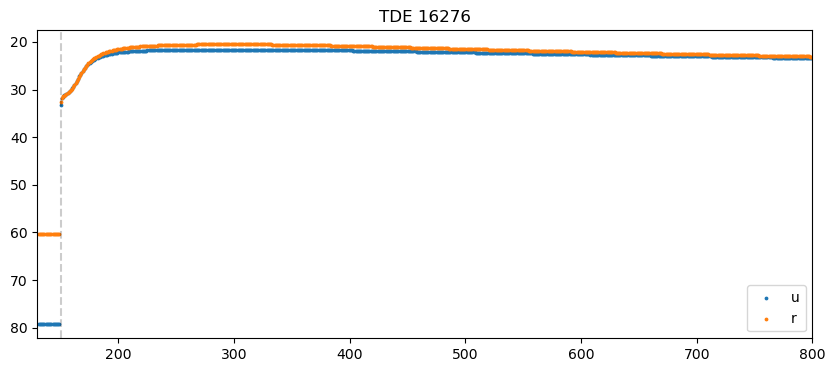

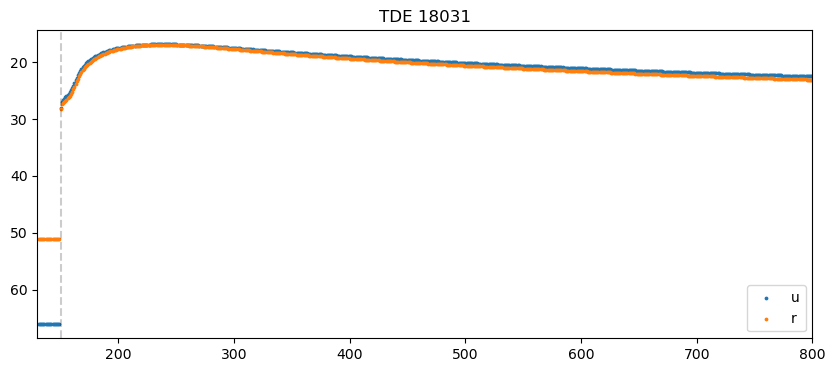

In [30]:

for i in range(5):
    idx = np.random.randint(0,24000)
    json_Tde = f"/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_{idx}.json"
    times,mags = get_MOSIFT(json_Tde)

    while np.min(mags['u'])>24:
        idx = np.random.randint(0,24000)
        json_Tde = f"/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_{idx}.json"
        times,mags = get_MOSIFT(json_Tde)
        
    plt.figure(figsize=(10,4))
    plt.axvline(150, color='k', ls='--', alpha=.2)
    plt.scatter(times, mags['u'], label='u', s=3)
    plt.scatter(times, mags['r'], label='r', s=3)
    plt.legend()
    plt.gca().invert_yaxis()
    plt.title(f"TDE {idx}")
    plt.xlim(130,800)
    

In [7]:
dir_lsst = "/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/lsst_synth_mosfitdays/"
idx=40
dflc= pd.read_csv(dir_lsst+f"synth_tde_{idx}.csv")
dflc

,Unnamed: 0,timeMJD,mags,truemags,errors,SNRs,filter,MOSFITday
0,0,60823.428577,506.855136,34.127337,3324.328794,0.000328,i,3.0
1,1,60830.322887,368.872284,33.702240,1468.371617,0.000742,g,10.0
2,2,60830.347903,-1297.443072,33.907119,2256.963832,0.000483,r,10.0
3,3,60830.431383,4561.976482,34.127337,2807.179637,0.000388,i,10.0
4,4,60854.425257,-1970.995411,33.907119,2138.935424,0.000510,r,34.0
...,...,...,...,...,...,...,...,...
229,229,61776.048102,18.332453,18.338455,0.006170,176.669711,i,956.0
230,230,61776.048340,18.347539,18.338455,0.006321,172.453884,i,956.0
231,231,61776.051221,18.337488,18.338455,0.004417,246.776264,i,956.0
232,232,61776.051458,18.342146,18.338455,0.004534,240.384046,i,956.0


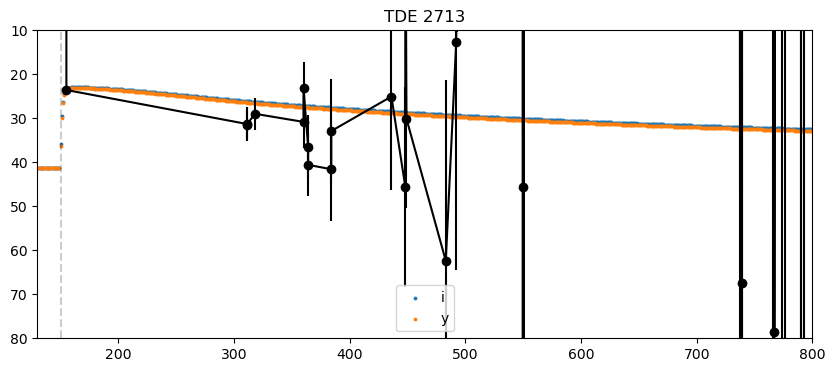

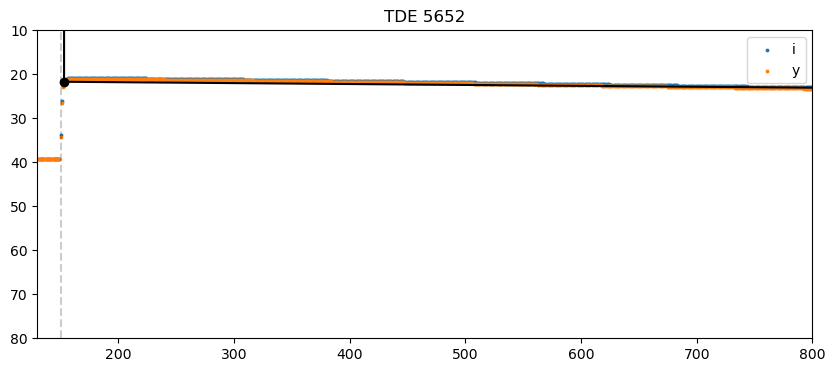

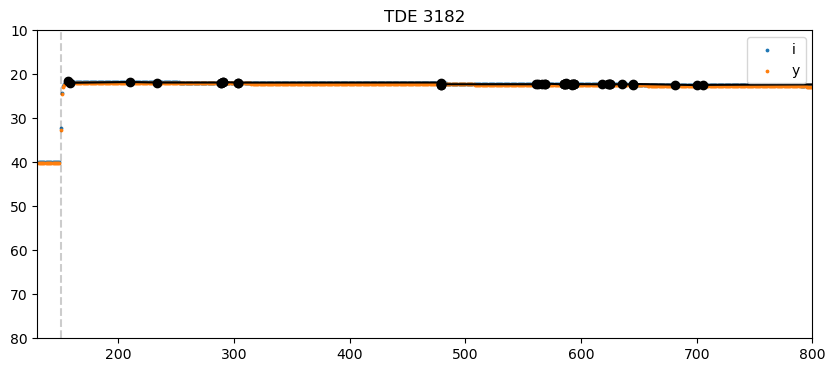

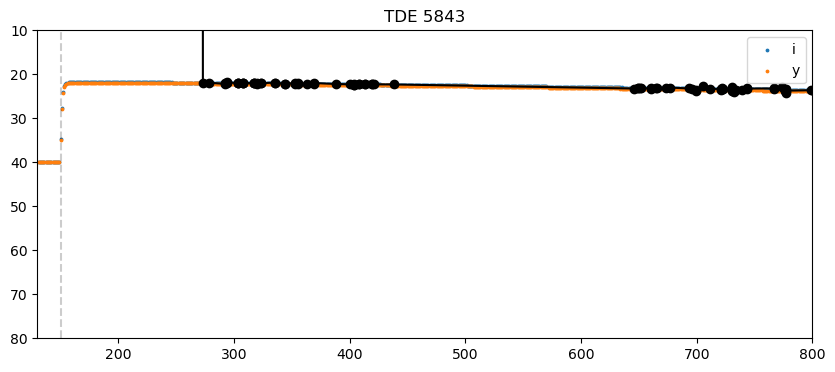

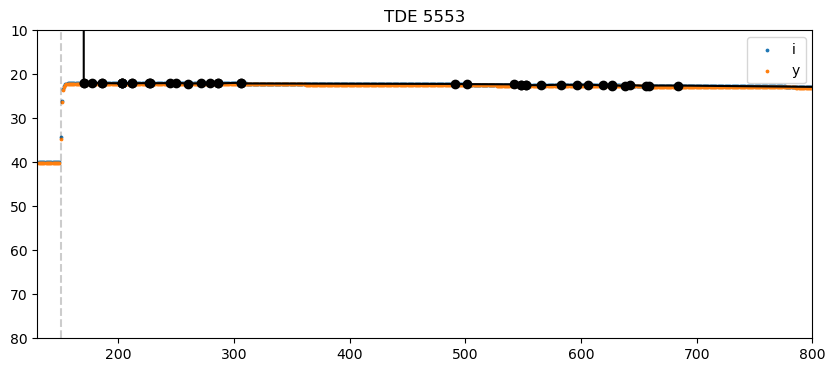

In [18]:

for i in range(5):
    idx = np.random.randint(0,10000)
    json_Tde = f"/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_{idx}.json"
    times,mags = get_MOSIFT(json_Tde)
    
    dflc= pd.read_csv(dir_lsst+f"synth_tde_{idx}.csv")

    while np.min(mags['u'])>24:
        idx = np.random.randint(0,10000)
        json_Tde = f"/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_{idx}.json"
        times,mags = get_MOSIFT(json_Tde)
        dflc= pd.read_csv(dir_lsst+f"synth_tde_{idx}.csv")

        
    plt.figure(figsize=(10,4))
    plt.axvline(150, color='k', ls='--', alpha=.2)
    plt.scatter(times, mags['i'], label='i', s=3)
    plt.scatter(times, mags['y'], label='y', s=3)
    
    mask = dflc['filter']=='i'
    plt.errorbar(dflc['MOSFITday'][mask], dflc['mags'][mask], yerr=dflc['errors'][mask], color='k',
                marker='o')
    
    plt.legend()
    plt.gca().invert_yaxis()
    plt.title(f"TDE {idx}")
    plt.xlim(130,800)
    plt.ylim(80,10)

In [19]:
pd.read_csv(dir_lsst+f"synth_tde_{5553}.csv")

,Unnamed: 0,timeMJD,mags,truemags,errors,SNRs,filter,MOSFITday
0,0,61244.427580,-2.317561e+05,40.023457,2.434470e+06,4.477361e-07,i,85.0
1,1,61244.427818,5.820762e+05,40.023457,2.482420e+06,4.390877e-07,i,85.0
2,2,61244.430698,1.224101e+06,40.023457,2.102504e+06,5.184295e-07,i,85.0
3,3,61244.430936,3.363662e+05,40.023457,2.161702e+06,5.042324e-07,i,85.0
4,4,61244.433816,-1.192232e+05,40.023457,2.231465e+06,4.884684e-07,i,85.0
...,...,...,...,...,...,...,...,...
249,249,62139.265381,2.287352e+01,23.258448,3.680947e-01,2.961194e+00,z,980.0
250,250,62142.222805,2.314418e+01,23.264050,3.112788e-01,3.501684e+00,z,983.0
251,251,62142.246851,2.311660e+01,23.374714,6.917300e-01,1.575759e+00,y,983.0
252,252,62150.169599,2.304472e+01,23.007021,8.361152e-02,1.303648e+01,g,991.0
